In [1]:
import numpy as np
import random
import math
import networkx as nx
import matplotlib.pyplot as plt
import os

In [2]:
%run ./Generate_Network_Topology.ipynb

In [3]:
%run ./Generating_CRs.ipynb 

In [3]:
%run ./Links.ipynb

In [5]:
# Define the subdirectory name
subdirectory = "Figures"

# Check if the subdirectory exists
if not os.path.exists(subdirectory):
    os.makedirs(subdirectory)


In [6]:
# 21 Edges
edges = [ (1, 2, 1100),  #Edge between Node 0 and Node 1
             (2, 3, 1600), #Intermediate Edge between Node 1 and Node 2
             (1, 3, 600), # Edge between Node 0 and Node 2
             (2, 8, 1500), # Edge between Node 1 and Node 7
             (1, 4, 1000),  # Edge between Node 0 and Node 3
             
         (4, 5, 600), # Edge between Node 3 and Node 4
             (5, 7, 800), # Intermediate edge between Node 4 and Node 6
             (7, 8, 700), # Intermediate edge between Node 6 and Node 7
             (10, 11, 900), # Edge Betweeen Node 9 and Node 10
             (4, 9, 1500), # Edge Betweeen Node 3 and Node 8
         
         (9, 12, 800), # Edge Betweeen Node 8 and Node 11
             (8, 10, 700), # Edge Betweeen Node 7 and Node 9
             (10, 12, 500), # Edge Betweeen Node 9 and Node 11
             (9, 14, 800), # Edge Betweeen Node 8 and Node 13
             (10, 14, 500), # Edge Betweeen Node 9 and Node 13
         
         (12, 13, 300), # Edge Betweeen Node 11 and Node 12
             (13, 14, 300), # Edge Betweeen Node 12 and Node 13
             (3, 6, 1000), # Edge Betweeen Node 2 and Node 5
             (6, 5, 1100), # Edge Betweeen Node 5 and Node 4
             (6, 13, 2000), # Edge Betweeen Node 5 and Node 12
         
         (6, 11, 1200), # Edge Betweeen Node 5 and Node 10
        ]

# Step 1:
Initialize the network status and parameters, and generate a set of CR, i.e., X CRs.
## Step 2(a) : 
For each CR, we set a SL (incorporated in Step 1)

Number of Nodes:  14
Number of Links : 21


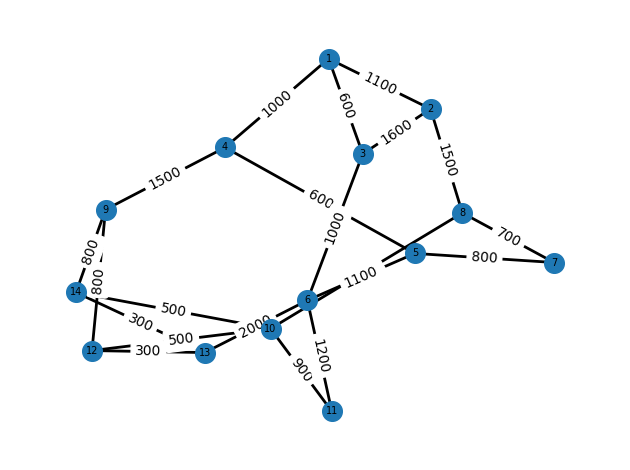

In [7]:
g_nsfnet = create_topology(edges) # Creates the nsfnet topology
links, indices, unordered_indices = Links.initialize_links(edges) # Initializes the links structure with weights

numNodes = len(g_nsfnet)
X = 100    # Just an example
CRs = CR.generate_crs(X) # Generating X Crs. 

In [8]:
# Print the array of CR instances
print("CR info : ")
for cr in CRs:
    cr.display_info()

# Print link info
'''
for link in links[indices]:    # Will display double the number of actual edges, due to ordered pair
   link.display_info()
'''
print("Link info : ")
Links.display_all_links()

CR info : 
CR: Index : 0, Source Node =13, Destination Node=10, Security Level=low, status=initialized, allocated resources = [None, None], Path : None
CR: Index : 1, Source Node =3, Destination Node=14, Security Level=low, status=initialized, allocated resources = [None, None], Path : None
CR: Index : 2, Source Node =9, Destination Node=5, Security Level=medium, status=initialized, allocated resources = [None, None], Path : None
CR: Index : 3, Source Node =2, Destination Node=6, Security Level=medium, status=initialized, allocated resources = [None, None], Path : None
CR: Index : 4, Source Node =5, Destination Node=3, Security Level=medium, status=initialized, allocated resources = [None, None], Path : None
CR: Index : 5, Source Node =7, Destination Node=10, Security Level=high, status=initialized, allocated resources = [None, None], Path : None
CR: Index : 6, Source Node =10, Destination Node=14, Security Level=medium, status=initialized, allocated resources = [None, None], Path : No

# Step 2(b) :
use the K-SP algorithm to obtain the K candidate transmission paths. 
The path with the shortest distance is selected as the transmission path of QSC and PIC.

In [9]:
cr = CRs[0]    # Taking only 1 cr for now. Later it can be converted to for loop to loop over all CRs

k_sp = cr.k_sp(g_nsfnet, 10)    # Taking k = 10
candidate_path = k_sp[0][0]    # Path with the shortest distance becomes the transmission path

In [10]:
# Displaying all the K shortest paths along with their path costs
for i, (path, cost) in enumerate(k_sp):
    print(f"Path {i + 1}: {path}, Cost: {cost}")

# Displaying the candidate path
print(f"Candidate path : {candidate_path}")

Path 1: [13, 12, 10], Cost: 800
Path 2: [13, 14, 10], Cost: 800
Path 3: [13, 12, 9, 14, 10], Cost: 2400
Path 4: [13, 14, 9, 12, 10], Cost: 2400
Path 5: [13, 6, 11, 10], Cost: 4100
Path 6: [13, 6, 5, 7, 8, 10], Cost: 5300
Path 7: [13, 12, 9, 4, 5, 7, 8, 10], Cost: 5400
Path 8: [13, 14, 9, 4, 5, 7, 8, 10], Cost: 5400
Path 9: [13, 12, 9, 4, 5, 6, 11, 10], Cost: 6400
Path 10: [13, 14, 9, 4, 5, 6, 11, 10], Cost: 6400
Candidate path : [13, 12, 10]


In [11]:
# Allocate to TDC and QSC

In [12]:
# if no time slot is available, we move on to the next candidate path
cr = CRs[0]
attempt = Links.FF(candidate_path, cr)
print(f"CR status : {cr.status}, on path : {candidate_path}, allocated resources : {cr.allocated_resources}")

CR status : allocated, on path : [13, 12, 10], allocated resources : [3, 0]


# Step3：
If a CR is successfully allocated to TDC & QSC, turn to Step4; otherwise, this CR blocks. If an event is waiting for a CR(X=0), turn to Step9


In [13]:
if attempt:
    print(f"CR status : {cr.status}, on path : {candidate_path}, allocated resources : {cr.allocated_resources}" )
else :
    print("CR couldn't be successfully allocated on path :", candidate_path)

CR status : allocated, on path : [13, 12, 10], allocated resources : [3, 0]


In [14]:
# Displaying the resources after allocation
path = candidate_path
for s, d in zip(path, path[1:]):
    links[s, d].display_info()
    #links[s, d].wl_info()

Link (12, 13) : lambda_tdc_count = 46, lambda_q1_count = 8, lambda_q2_count = 10, lambda_q3_count = 11, occupied_ts = [1 0 0 1], available_ts = [29  8 10 11]
Link (10, 12) : lambda_tdc_count = 46, lambda_q1_count = 8, lambda_q2_count = 10, lambda_q3_count = 11, occupied_ts = [1 0 0 1], available_ts = [29  8 10 11]


# Step 4 :
Create three queues with different priorities in PQ={𝑪𝑹1, 𝑪𝑹0, 𝑪𝑹−1}, i.e., 𝑪𝑹1, 𝑪𝑹0 and 𝑪𝑹−1. Each CR has a specific SL, sl. 
Place the CR of the corresponding SL in the corresponding priority. If this CR belongs to the high-level priority queue, 𝑪𝑹1, then turn to Step 5. 
If this CR belongs to mid-level priority queue 𝑪𝑹0 or low-level priority queue, 𝑪𝑹−1, turn to Step 6.


In [15]:
PQ = CR.create_priority_queue()

In [16]:
#CR.display_all(PQ)

# Trying Manually

In [17]:
'''
Let's assume we have 800 CRs, all dealt with.
Manually calculating TUR : calculate total number of used slots. divided by total slots(already known)
2 approaches : 
CR approach : for every allocated CR, we take the number of links in its path = len(path)-1. This will be the occupied slots by a particular cr. Can calculate SRCR and NSP as well
Links approach : count the nonzero elements in each link(unordered_indices) band.
'''

"\nLet's assume we have 800 CRs, all dealt with.\nManually calculating TUR : calculate total number of used slots. divided by total slots(already known)\n2 approaches : \nCR approach : for every allocated CR, we take the number of links in its path = len(path)-1. This will be the occupied slots by a particular cr. Can calculate SRCR and NSP as well\nLinks approach : count the nonzero elements in each link(unordered_indices) band.\n"

In [ ]:
X = 600
# Parameters used later
k = 5
   
# Initializes the links structure with weights
(links, indices, unordered_indices) = Links.initialize_links(edges) 

# Generating X Crs
CRs = CR.generate_crs(X) 

########################################################################
    
# Creating the priority Queue
PQ = CR.create_priority_queue()

for cr in PQ:  
            
    k_sp = cr.k_sp(g_nsfnet, k)    # Taking k = 10. Gives us [path][weight]
    # Finding the path to be followed
    for i in range(k):    # Using the next k-sp in case the CR couldn't be allocated to the previous one
        candidate_path = k_sp[i][0]    # Path with the lowest weight so far becomes the transmission path
        print(f"\nAttempting allocation of CR {cr.index} on path : {candidate_path}")
        
        # Attempting to allocate resources
        success = Links.FF(candidate_path, cr)
        print(f"CR {cr.index} status : {cr.status}, on path :", candidate_path)
        # Checking if the path was allocated or not
        if success:
            break  

        #X = X-1

In [19]:
# CR approach(cra) : for tur, nsp and srcr

#X = 800
"""
cra_tur = np.zeros(j_range).astype(int)
cra_srcr = np.zeros(j_range).astype(int)
cra_nsp = np.zeros(j_range).astype(int)
"""
cra_nsp = 0
cra_tur = 0
cra_srcr = 0
for i, cr in enumerate(PQ):    # PQ_all[1] is for crs with high priority
    if cr.status == 'allocated':
        cra_tur += (len(cr.path) - 1)
        cra_srcr += 1
        cra_nsp += CR.sfw[cr.sl]

cra_tur /= (Links.total_ts * len(edges))
cra_srcr /= len(CRs)

In [20]:
print((Links.total_ts * len(edges)))

630


In [21]:
print(cra_tur, cra_nsp, cra_srcr)

0.9158730158730158 1116 0.48


In [22]:
# Links approach(la): Only for tur

#X = 800
la_tur0 = 0
la_tur = np.zeros(4)
for nodes in Links.unordered_indices:
    la_tur0 += (Links.links[nodes].occupied_ts[0])
    la_tur += Links.links[nodes].occupied_ts

la_tur0 /= Links.total_ts * len(edges)
la_tur[0] = la_tur0
for i in range(1, 4):
    la_tur[i] /= len(edges) * Links.channel_ts[i]

print(la_tur)
print(la_tur0)


0.9158730158730158
[0.91587302 0.6625     0.62666667 0.63888889]


In [23]:
print(la_tur, la_tur1)

[0.91587302 0.6625     0.62666667 0.63888889] 0.9158730158730158


In [ ]:
#CR.display_all(PQ)

# Combined

## QKRA

Network topology can be initialized once at the start. Only Links need to be initialized everytime

In [ ]:
#%%capture
# Creates the nsfnet topology
g_nsfnet = create_topology(edges) 
numNodes = len(g_nsfnet)

# Set the ASLC
aslc = "ASSL"

# Open the file to write data to
filename = "QKRA-" + aslc + ".txt"
data_path = os.path.join(data_subdirectory, filename)
file = open(data_path, "a")

# Modify : X, k, num_iter, j_range, factor, expression of X in QKRA.ipynb
X = 600   
k = 5    # K sp
num_iter = 10    # Average over
j_range = 6    # X steps
#factor = int(input("Input the multiplication factor"))
factor = 50    # Step multiplication factor. 10 if X>=100

# Initializing the arrays to store data of j_range X for num_iter
srcr = np.zeros([num_iter, j_range])
tur = np.zeros([num_iter, j_range])
nsp = np.zeros([num_iter, j_range]).astype(int)
x = np.zeros([num_iter, j_range]).astype(int)

file.write("QKRA-" + aslc + " : " + "k = " + str(k) + ", Averaged over(z) = " + str(num_iter) + "\n")

for z in range(num_iter):    # Loop to average over the same list of X

    #X = int(input("Input the number of CRs to be generates"))
    #X = 60*factor
    
    j = 0    
    %run ./QKRA.ipynb
    print(f"Iteration {z+1} complete \n\n")

 
print("Simulation Ended")

In [25]:
print(srcr, tur, nsp, x)

[[0.28666667 0.25384615 0.27142857 0.24       0.2425     0.21176471]
 [0.30833333 0.26307692 0.25142857 0.256      0.24125    0.21411765]
 [0.29333333 0.28615385 0.26571429 0.24133333 0.23375    0.22235294]
 [0.29166667 0.26461538 0.27857143 0.25066667 0.2325     0.21882353]
 [0.285      0.28615385 0.26142857 0.25466667 0.23625    0.21882353]
 [0.28166667 0.26615385 0.27571429 0.256      0.24       0.22352941]
 [0.29666667 0.27076923 0.27571429 0.24666667 0.24125    0.21882353]
 [0.29666667 0.28153846 0.25142857 0.24666667 0.24125    0.22117647]
 [0.30833333 0.26769231 0.25428571 0.236      0.22875    0.22823529]
 [0.29666667 0.28769231 0.24714286 0.24533333 0.2225     0.23764706]] [[0.54603175 0.54920635 0.56984127 0.56666667 0.56349206 0.56666667]
 [0.56190476 0.54761905 0.56190476 0.57301587 0.56190476 0.58730159]
 [0.55873016 0.57619048 0.56031746 0.56984127 0.56031746 0.58412698]
 [0.56825397 0.54761905 0.57619048 0.57301587 0.56507937 0.57936508]
 [0.55555556 0.55714286 0.5682539

In [26]:
avg_srcr = np.zeros(j_range)
avg_tur = np.zeros(j_range)
avg_nsp = np.zeros(j_range)
avg_x = np.zeros(j_range)

for j in range((j_range)):
    for i in range(num_iter):
        avg_srcr[j] += srcr[i, j] 
        avg_tur[j] += tur[i, j] 
        avg_nsp[j] += nsp[i, j] 
        avg_x[j] += x[i, j] 

avg_srcr /= num_iter
avg_tur /= num_iter 
avg_nsp /= num_iter
avg_x /= num_iter 
file.write("X range : " + str(avg_x) + "\n Average SRCR : " + str(avg_srcr) + "\n Average TUR : " + str(avg_tur) + "\n" )
file.close()

In [27]:
print(avg_srcr, avg_tur, avg_nsp, avg_x)

[0.2945     0.27276923 0.26328571 0.24733333 0.236      0.22152941] [0.55825397 0.56095238 0.56746032 0.57285714 0.5684127  0.58047619] [689.9 692.4 719.3 721.9 739.5 737.2] [600. 650. 700. 750. 800. 850.]


In [28]:
print(len(srcr), len(tur), len(nsp), len(x))

10 10 10 10


# Plotting the data

**SRCR and TUR**

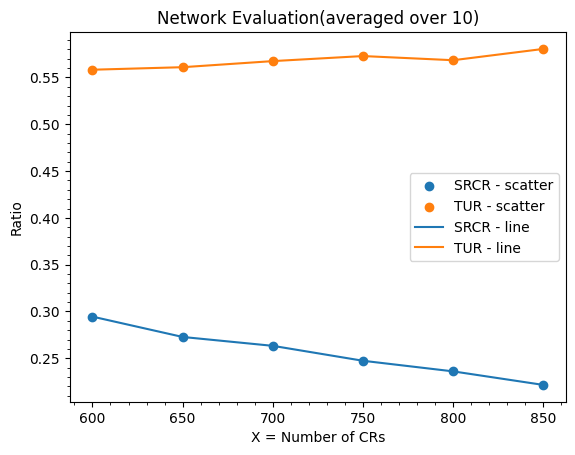

SRCR and TUR for X - 600.0 to 850.0.jpg


In [29]:
#y = [item[0] for item in tur]
plt.scatter(avg_x, avg_srcr, label='SRCR - scatter')
plt.scatter(avg_x, avg_tur, label='TUR - scatter')

plt.plot(avg_x, avg_srcr, label='SRCR - line')
plt.plot(avg_x, avg_tur, label='TUR - line')

plt.minorticks_on()
plt.xlabel('X = Number of CRs')
plt.ylabel('Ratio')
plt.title(f"Network Evaluation(averaged over {num_iter}, k = {k})")
plt.legend()
plt.show()

filename = f"z = {num_iter}, k = {k}, SRCR and TUR for X - {str(avg_x[0])} to {str(avg_x[-1])}.jpg"
print(filename)

# Combine the subdirectory and filename to create the full path
full_path = os.path.join(subdirectory, filename)

#plt.savefig(full_path, dpi=300, bbox_inches='tight')


In [32]:
filename1 = f"z = {num_iter}, k = {k}, SRCR and TUR for X - {str(avg_x[0])} to {str(avg_x[-1])}.jpg"
print(filename1)

z = 10, k = 5, SRCR and TUR for X - 600.0 to 850.0.jpg


**NSP**

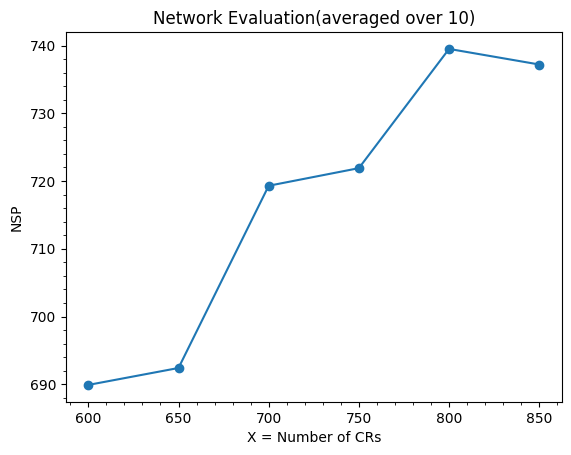

NSP for X - 600.0 to 850.0.jpeg


<Figure size 640x480 with 0 Axes>

In [33]:
#y = [item[0] for item in nsp]
plt.scatter(avg_x, avg_nsp)
plt.plot(avg_x, avg_nsp)

plt.minorticks_on()
plt.xlabel('X = Number of CRs')
plt.ylabel('NSP')
plt.title(f"Network Evaluation(averaged over {num_iter}, k = {k})")
#plt.legend()
plt.show()

filename = f"NSP for X - {str(avg_x[0])} to {str(avg_x[-1])}.jpeg"
print(filename)

# Combine the subdirectory and filename to create the full path
full_path = os.path.join(subdirectory, filename)

plt.savefig(full_path, dpi=300, bbox_inches='tight')


In [31]:
for i in range(j_range):
    print(f"\nfor X = {5*(2 + i)*factor}")
    print(f"\nSRCR {i} : {srcr[i]}")
    print(f"\nNSP {i} : {nsp[i]}")
    print(f"\nTUR {i} : {tur[i]}")


for X = 100

SRCR 0 : [0.28666667 0.25384615 0.27142857 0.24       0.2425     0.21176471]

NSP 0 : [675 656 738 696 755 711]

TUR 0 : [0.54603175 0.54920635 0.56984127 0.56666667 0.56349206 0.56666667]

for X = 150

SRCR 1 : [0.30833333 0.26307692 0.25142857 0.256      0.24125    0.21411765]

NSP 1 : [717 676 689 744 756 709]

TUR 1 : [0.56190476 0.54761905 0.56190476 0.57301587 0.56190476 0.58730159]

for X = 200

SRCR 2 : [0.29333333 0.28615385 0.26571429 0.24133333 0.23375    0.22235294]

NSP 2 : [694 717 732 711 735 747]

TUR 2 : [0.55873016 0.57619048 0.56031746 0.56984127 0.56031746 0.58412698]

for X = 250

SRCR 3 : [0.29166667 0.26461538 0.27857143 0.25066667 0.2325     0.21882353]

NSP 3 : [682 680 752 724 739 739]

TUR 3 : [0.56825397 0.54761905 0.57619048 0.57301587 0.56507937 0.57936508]

for X = 300

SRCR 4 : [0.285      0.28615385 0.26142857 0.25466667 0.23625    0.21882353]

NSP 4 : [672 721 720 742 738 722]

TUR 4 : [0.55555556 0.55714286 0.56825397 0.57936508 0.576190

AttributeError: type object 'Links' has no attribute 'unordered_indices'